# FIFA 2022 World Cup Prediction

In [1]:
import numpy as np
import pandas as pd
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

## Data Processing

In [2]:
data_clean = pd.read_csv('data/data_clean_double3.csv')
data_clean.head()

,Unnamed: 0,Year,home_team,home_gdp,home_population,home_oddset,home_fifa_rank,home_host,away_team,away_gdp,away_population,away_oddset,away_fifa_rank,away_host,home_goal,away_goal,win_point,result
0,0,1930,FRA,46984,6528,550,2,0,MEX,18445,12894,15000,11,0,4,1,3,1
1,1,1930,USA,63594,33101,10000,20,0,BEL,53035,1159,1200,1,0,3,0,3,1
2,2,1930,ROU,32117,1924,200000,43,0,PER,11879,3298,20000,27,0,3,1,2,1
3,3,1930,ARG,20771,4520,900,8,0,FRA,46984,6528,550,2,0,1,0,1,1
4,4,1930,ARG,20771,4520,900,8,0,MEX,18445,12894,15000,11,0,6,3,3,1


In [3]:
# generate rank
fifa = pd.read_csv('data/fifa.csv')
f = lambda x: str(x[:4])
rank_year = fifa['rank_date'].apply(f)
fifa = fifa.drop(columns = ['rank_date'])
fifa['rank_year'] = rank_year
def get_fifa_rank_records(name,year):
    country_records = fifa.loc[(fifa['country_abrv']==name)]
    country_records['rank_year'] = country_records['rank_year'].astype(int)
    country_records.sort_values("rank_year",inplace=True, ascending=False)
    records = country_records.loc[country_records['rank_year']<=year]
    return records

### Add feature columns

In [4]:
# add Features columns
# add Total GDP difference between home and away
data_clean['GDP_Diff'] = data_clean['home_gdp'] - data_clean['away_gdp']
# add GDP per capita between home and away
data_clean['PersonGDP_Diff'] = (data_clean['home_gdp']/data_clean['home_population']) - (data_clean['away_gdp']/data_clean['away_population'])
# add population difference
data_clean['Population_Diff'] = data_clean['home_population'] - data_clean['away_population']
# add oddset difference
data_clean['Oddset_Diff'] = data_clean['home_oddset'] - data_clean['away_oddset']
# add rank difference
data_clean['Rank_Diff'] = data_clean['home_fifa_rank'] - data_clean['away_fifa_rank']
data_clean.head()

,Unnamed: 0,Year,home_team,home_gdp,home_population,home_oddset,home_fifa_rank,home_host,away_team,away_gdp,...,away_host,home_goal,away_goal,win_point,result,GDP_Diff,PersonGDP_Diff,Population_Diff,Oddset_Diff,Rank_Diff
0,0,1930,FRA,46984,6528,550,2,0,MEX,18445,...,0,4,1,3,1,28539,5.766794,-6366,-14450,-9
1,1,1930,USA,63594,33101,10000,20,0,BEL,53035,...,0,3,0,3,1,10559,-43.838064,31942,8800,19
2,2,1930,ROU,32117,1924,200000,43,0,PER,11879,...,0,3,1,2,1,20238,13.090948,-1374,180000,16
3,3,1930,ARG,20771,4520,900,8,0,FRA,46984,...,0,1,0,1,1,-26213,-2.601950,-2008,350,6
4,4,1930,ARG,20771,4520,900,8,0,MEX,18445,...,0,6,3,3,1,2326,3.164844,-8374,-14100,-3


In [5]:
# caculate the win/draw/lose rate use the previous data
# for example: 2018 USA(home) vs FRA(away)
#              Team_Total = all data from 1930-2014 where USA is included
#              Win = all data from 1930-2014 where USA is winner
#              Home_Win_Rate = Win / Team_Total
# caculate the Average goal difference
# for example: 2018 USA(home) vs FRA(away)
#              Team_Total = all data from 1930-2014 where USA is included
#              WinGoals = all goals from 1930-2014 where USA is winner
#              Home_Goal_Avg = WinGoals / Team_Total
def calculate_rate(dataset,TeamHome,TeamAway,Year):
  Home_Team_Total = dataset.loc[((dataset['home_team']==TeamHome)&(dataset['Year']<Year))]
  Home_Team_Total2 = dataset.loc[((dataset['away_team']==TeamHome)&(dataset['Year']<Year))]
  Home_Team_Win = dataset.loc[((dataset['home_team']==TeamHome)&(dataset['Year']<Year)&(dataset['result'] == 1))]
  Home_Team_Win2 = dataset.loc[((dataset['away_team']==TeamHome)&(dataset['Year']<Year)&(dataset['result'] == -1))]
  Home_Team_Draw = dataset.loc[((dataset['home_team']==TeamHome)&(dataset['Year']<Year)&(dataset['result'] == 0))]
  Home_Team_Draw2 = dataset.loc[((dataset['away_team']==TeamHome)&(dataset['Year']<Year)&(dataset['result'] == 0))]
  Home_Team_Lose = dataset.loc[((dataset['home_team']==TeamHome)&(dataset['Year']<Year)&(dataset['result'] == -1))]
  Home_Team_Lose2 = dataset.loc[((dataset['away_team']==TeamHome)&(dataset['Year']<Year)&(dataset['result'] == 1))]
  Home_Team_Total_Goals = Home_Team_Total['home_goal'].sum() + Home_Team_Total2['away_goal'].sum()

  TotalHome = Home_Team_Total['Year'].count() + Home_Team_Total2['Year'].count()
  if TotalHome == 0:
    Home_Team_Win_Percentage = 0
    Home_Team_Draw_Percentage = 0
    Home_Team_Lose_Percentage = 0
    Home_Team_Win_Goals_Avg = 0
    Home_Team_Lose_Goals_Avg = 0
    Home_Team_AVG_Goals = 0
  else:
    Home_Team_Win_Percentage = (Home_Team_Win['Year'].count() + Home_Team_Win2['Year'].count())/TotalHome
    Home_Team_Draw_Percentage = (Home_Team_Draw['Year'].count() + Home_Team_Draw2['Year'].count())/TotalHome
    Home_Team_Lose_Percentage = (Home_Team_Lose['Year'].count() + Home_Team_Lose2['Year'].count())/TotalHome
    Home_Team_Win_Goals_Avg = (Home_Team_Win['win_point'].sum() - Home_Team_Win2['win_point'].sum())/TotalHome
    Home_Team_Lose_Goals_Avg = (Home_Team_Lose['win_point'].sum() - Home_Team_Lose2['win_point'].sum())/TotalHome
    Home_Team_AVG_Goals = Home_Team_Total_Goals / TotalHome

  Away_Team_Total = dataset.loc[((dataset['away_team']==TeamAway)&(dataset['Year']<Year))]
  Away_Team_Total2 = dataset.loc[((dataset['home_team']==TeamAway)&(dataset['Year']<Year))]
  Away_Team_Win = dataset.loc[((dataset['away_team']==TeamAway)&(dataset['Year']<Year)&(dataset['result'] == -1))]
  Away_Team_Win2 = dataset.loc[((dataset['home_team']==TeamAway)&(dataset['Year']<Year)&(dataset['result'] == 1))]
  Away_Team_Draw = dataset.loc[((dataset['away_team']==TeamAway)&(dataset['Year']<Year)&(dataset['result'] == 0))]
  Away_Team_Draw2 = dataset.loc[((dataset['home_team']==TeamAway)&(dataset['Year']<Year)&(dataset['result'] == 0))]
  Away_Team_Lose = dataset.loc[((dataset['away_team']==TeamAway)&(dataset['Year']<Year)&(dataset['result'] == 1))]
  Away_Team_Lose2 = dataset.loc[((dataset['home_team']==TeamAway)&(dataset['Year']<Year)&(dataset['result'] == -1))]
  Away_Team_Total_Goals = Away_Team_Total['away_goal'].sum() + Away_Team_Total2['home_goal'].sum()

  TotalAway = Away_Team_Total['Year'].count() + Away_Team_Total2['Year'].count()
  if TotalAway == 0:
    Away_Team_Win_Percentage = 0
    Away_Team_Draw_Percentage = 0
    Away_Team_Lose_Percentage = 0
    Away_Team_Win_Goals_Avg = 0
    Away_Team_Lose_Goals_Avg = 0
    Away_Team_AVG_Goals = 0
  else:
    Away_Team_Win_Percentage = (Away_Team_Win['Year'].count() + Away_Team_Win2['Year'].count())/TotalAway
    Away_Team_Draw_Percentage = (Away_Team_Draw['Year'].count() + Away_Team_Draw2['Year'].count())/TotalAway
    Away_Team_Lose_Percentage = (Away_Team_Lose['Year'].count() + Away_Team_Lose2['Year'].count())/TotalAway
    Away_Team_Win_Goals_Avg = (Away_Team_Win2['win_point'].sum() - Away_Team_Win['win_point'].sum())/TotalAway
    Away_Team_Lose_Goals_Avg = (Away_Team_Lose2['win_point'].sum() - Away_Team_Lose['win_point'].sum())/TotalAway
    Away_Team_AVG_Goals = Away_Team_Total_Goals / TotalAway

  Win_Rate_Diff = Home_Team_Win_Percentage - Away_Team_Win_Percentage
  Draw_Rate_Diff = Home_Team_Draw_Percentage - Away_Team_Draw_Percentage 
  Lose_Rate_Diff = Home_Team_Lose_Percentage - Away_Team_Lose_Percentage
  Win_Goals_Diff = Home_Team_Win_Goals_Avg - Away_Team_Win_Goals_Avg
  Lose_Goals_Diff = Home_Team_Lose_Goals_Avg - Away_Team_Lose_Goals_Avg
  AVG_Goals_Diff = Home_Team_AVG_Goals - Away_Team_AVG_Goals

  return {'Home_Team_Win_Rate': Home_Team_Win_Percentage,
        'Home_Team_Draw_Rate': Home_Team_Draw_Percentage,
        'Home_Team_Lose_Rate':Home_Team_Lose_Percentage,
        'Away_Team_Win_Rate': Away_Team_Win_Percentage,
        'Away_Team_Draw_Rate': Away_Team_Draw_Percentage,
        'Away_Team_Lose_Rate': Away_Team_Lose_Percentage,
        'Win_Rate_Diff': Win_Rate_Diff,
        'Draw_Rate_Diff': Draw_Rate_Diff,
        'Lose_Rate_Diff': Lose_Rate_Diff,
        'Home_Team_Win_Goals_Avg': Home_Team_Win_Goals_Avg,
        'Home_Team_Lose_Goals_Avg': Home_Team_Lose_Goals_Avg,
        'Away_Team_Win_Goals_Avg': Away_Team_Win_Goals_Avg,
        'Away_Team_Lose_Goals_Avg': Away_Team_Lose_Goals_Avg,
        'Win_Goals_Diff': Win_Goals_Diff,
        'Lose_Goals_Diff': Lose_Goals_Diff,
        'Home_Team_AVG_Goals': Home_Team_AVG_Goals,
        'Away_Team_AVG_Goals': Away_Team_AVG_Goals,
        'AVG_Goals_Diff': AVG_Goals_Diff
        }

### Input

In [6]:
# Create the new dataframe for Machine Learning input
FinalData = []
for index, row in data_clean.iterrows():
  ProcessedData = {}
  Rate = calculate_rate(data_clean,row['home_team'],row['away_team'],row['Year'])
  ProcessedData['Year'] = row['Year']
  ProcessedData['home_team'] = row['home_team']
  ProcessedData['away_team'] = row['away_team']
  ProcessedData['result'] = row['result']
  ProcessedData['GDP_Diff'] = row['GDP_Diff']
  ProcessedData['PersonGDP_Diff'] = row['PersonGDP_Diff']
  ProcessedData['Population_Diff'] = row['Population_Diff']
  ProcessedData['Oddset_Diff'] = row['Oddset_Diff']
  ProcessedData['Rank_Diff'] = row['Rank_Diff']
  ProcessedData['Home_Team_Win_Rate'] = Rate['Home_Team_Win_Rate']
  ProcessedData['Home_Team_Draw_Rate'] = Rate['Home_Team_Draw_Rate']
  ProcessedData['Home_Team_Lose_Rate'] = Rate['Home_Team_Lose_Rate']
  ProcessedData['Away_Team_Win_Rate'] = Rate['Away_Team_Win_Rate']
  ProcessedData['Away_Team_Draw_Rate'] = Rate['Away_Team_Draw_Rate']
  ProcessedData['Away_Team_Lose_Rate'] = Rate['Away_Team_Lose_Rate']
  ProcessedData['Win_Rate_Diff'] = Rate['Win_Rate_Diff']
  ProcessedData['Draw_Rate_Diff'] = Rate['Draw_Rate_Diff']
  ProcessedData['Lose_Rate_Diff'] = Rate['Lose_Rate_Diff']
  ProcessedData['Home_Team_Win_Goals_Avg'] = Rate['Home_Team_Win_Goals_Avg']
  ProcessedData['Home_Team_Lose_Goals_Avg'] = Rate['Home_Team_Lose_Goals_Avg']
  ProcessedData['Away_Team_Win_Goals_Avg'] = Rate['Away_Team_Win_Goals_Avg']
  ProcessedData['Away_Team_Lose_Goals_Avg'] = Rate['Away_Team_Lose_Goals_Avg']
  ProcessedData['Win_Goals_Diff'] = Rate['Win_Goals_Diff']
  ProcessedData['Lose_Goals_Diff'] = Rate['Lose_Goals_Diff']
  ProcessedData['Home_Team_AVG_Goals'] = Rate['Home_Team_AVG_Goals']
  ProcessedData['Away_Team_AVG_Goals'] = Rate['Away_Team_AVG_Goals']
  ProcessedData['AVG_Goals_Diff'] = Rate['AVG_Goals_Diff']
  ProcessedData['Sample_weights'] = ((row['Year'] % 1930) / 4 + 1)*(0.045)
  FinalData.append(ProcessedData)
Final_Processed_Data = pd.DataFrame(FinalData)
Final_Processed_Data = Final_Processed_Data.fillna(0)
Final_Processed_Data.head()


,Year,home_team,away_team,result,GDP_Diff,PersonGDP_Diff,Population_Diff,Oddset_Diff,Rank_Diff,Home_Team_Win_Rate,...,Home_Team_Win_Goals_Avg,Home_Team_Lose_Goals_Avg,Away_Team_Win_Goals_Avg,Away_Team_Lose_Goals_Avg,Win_Goals_Diff,Lose_Goals_Diff,Home_Team_AVG_Goals,Away_Team_AVG_Goals,AVG_Goals_Diff,Sample_weights
0,1930,FRA,MEX,1,28539,5.766794,-6366,-14450,-9,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045
1,1930,USA,BEL,1,10559,-43.838064,31942,8800,19,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045
2,1930,ROU,PER,1,20238,13.090948,-1374,180000,16,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045
3,1930,ARG,FRA,1,-26213,-2.601950,-2008,350,6,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045
4,1930,ARG,MEX,1,2326,3.164844,-8374,-14100,-3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045


In [7]:
Final_Processed_Data.to_csv('ProcessedDataForInput.csv')

In [8]:
Final_Processed_Data.columns

Index(['Year', 'home_team', 'away_team', 'result', 'GDP_Diff',
       'PersonGDP_Diff', 'Population_Diff', 'Oddset_Diff', 'Rank_Diff',
       'Home_Team_Win_Rate', 'Home_Team_Draw_Rate', 'Home_Team_Lose_Rate',
       'Away_Team_Win_Rate', 'Away_Team_Draw_Rate', 'Away_Team_Lose_Rate',
       'Win_Rate_Diff', 'Draw_Rate_Diff', 'Lose_Rate_Diff',
       'Home_Team_Win_Goals_Avg', 'Home_Team_Lose_Goals_Avg',
       'Away_Team_Win_Goals_Avg', 'Away_Team_Lose_Goals_Avg', 'Win_Goals_Diff',
       'Lose_Goals_Diff', 'Home_Team_AVG_Goals', 'Away_Team_AVG_Goals',
       'AVG_Goals_Diff', 'Sample_weights'],
      dtype='object')

In [9]:
# split Trainset and Testset
from sklearn.model_selection import train_test_split

DropC = ['result','home_team','away_team','Year','PersonGDP_Diff','Oddset_Diff','GDP_Diff','Population_Diff',
         'Home_Team_Win_Rate', 'Home_Team_Draw_Rate', 'Home_Team_Lose_Rate','Away_Team_Win_Rate', 'Away_Team_Draw_Rate', 'Away_Team_Lose_Rate',
         'Home_Team_Win_Goals_Avg', 'Home_Team_Lose_Goals_Avg','Away_Team_Win_Goals_Avg', 'Away_Team_Lose_Goals_Avg',
         'Home_Team_AVG_Goals', 'Away_Team_AVG_Goals']
X = Final_Processed_Data.drop(DropC, axis=1)
Y = Final_Processed_Data["result"]
Y = Y.astype('int')
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.10, random_state=42)
X_train

,Rank_Diff,Win_Rate_Diff,Draw_Rate_Diff,Lose_Rate_Diff,Win_Goals_Diff,Lose_Goals_Diff,AVG_Goals_Diff,Sample_weights
82,-24,0.428571,0.000000,-0.428571,1.190476,0.952381,1.380952,0.585
39,26,0.666667,0.000000,-0.666667,2.833333,2.700000,2.966667,0.360
531,27,0.000000,0.375000,-0.375000,-0.125000,0.083333,-0.083333,0.945
79,-20,0.261905,0.000000,-0.261905,1.690476,0.619048,2.130952,0.585
2,16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.045
...,...,...,...,...,...,...,...,...
71,-30,0.025000,0.087500,-0.112500,-0.987500,0.087500,-1.112500,0.585
106,5,-0.180952,0.092857,0.088095,-0.559524,0.019048,-0.692857,0.630
270,35,0.015385,-0.030769,0.015385,-0.130769,0.015385,-0.338462,0.990
435,-5,-0.166667,0.000000,0.166667,-0.500000,1.500000,-0.166667,0.765


### Add Sample weights

In [10]:
SampleWeight = X_train['Sample_weights']
X_train = X_train.drop(['Sample_weights'],axis=1)
X_test = X_test.drop(['Sample_weights'],axis=1)

In [11]:
def confusion_matrix_plot(cm):
    ax= sns.heatmap(cm, annot=True, fmt="d")
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['Loss', 'Draw','Win'])
    ax.yaxis.set_ticklabels(['Loss', 'Draw','Win'])
    return ax

## Model Training

### Decision Tree

In [12]:
from sklearn import tree

dt = tree.DecisionTreeClassifier(min_samples_split=2, max_depth=10)  

dt.fit(X_train, Y_train, sample_weight = SampleWeight)              
Trainscore = dt.score(X_train, Y_train)
Testscore = dt.score(X_test, Y_test)
print("Training Accuracy: " + str(Trainscore)) 
print("Test Accuracy: "+ str(Testscore))

Training Accuracy: 0.797270955165692
Test Accuracy: 0.5087719298245614


In [13]:
featnames = [x.strip() for x in X_train.columns]
print(featnames)

['Rank_Diff', 'Win_Rate_Diff', 'Draw_Rate_Diff', 'Lose_Rate_Diff', 'Win_Goals_Diff', 'Lose_Goals_Diff', 'AVG_Goals_Diff']


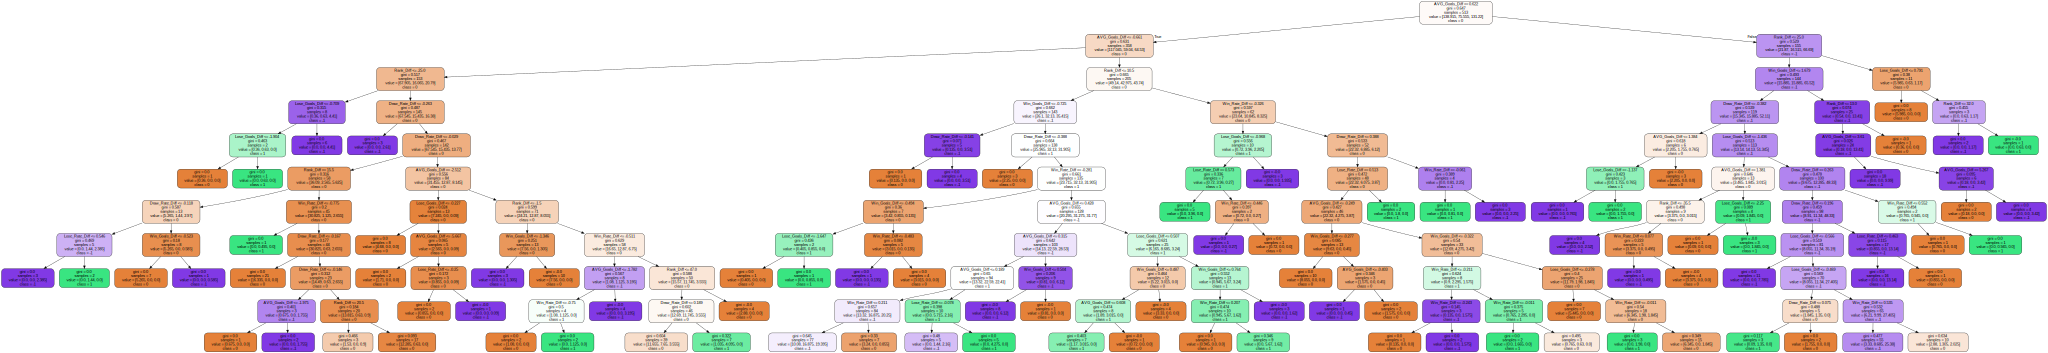

In [14]:
# !pip install graphviz
import graphviz
data=tree.export_graphviz(dt,feature_names=featnames
                     ,class_names=['0','1','-1']
                     ,filled=True
                     ,rounded=True
                    )
graph=graphviz.Source(data)
graph

### RandomForest

In [15]:
# Randomforest
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(max_depth=15, random_state=7)
RF.fit(X_train, Y_train,sample_weight = SampleWeight)
Trainscore = RF.score(X_train, Y_train)
Testscore = RF.score(X_test, Y_test)
print("Training Accuracy: " + str(Trainscore)) 
print("Test Accuracy: "+ str(Testscore))

Training Accuracy: 0.9766081871345029
Test Accuracy: 0.631578947368421


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted labels', ylabel='True labels'>

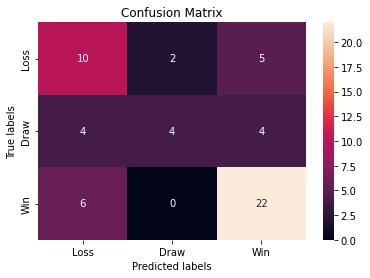

In [16]:
from sklearn.metrics import confusion_matrix 
pred_y = RF.predict(X_test)
cm = confusion_matrix(Y_test, pred_y)
confusion_matrix_plot(cm)

#### Confusion matrix and ROC curve for Random Forest

Random forest is the best classifier up to now, which accuracy is around 65%.   
From both confusion matrix and ROC curve, it could be clearly seen that our classifier has a good performance on predicting win/lose. However, it's hard for it to predice draw. 

In [17]:
from itertools import cycle

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

Highest accuracy 64.91228070175438  on  89


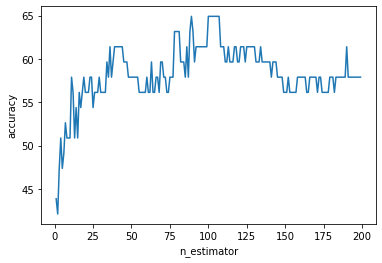

In [18]:
#Select number of trees

# highest_n = 0
# highest_acc = 0
# accuracy_scores = []
# n_list = range(1,200)
# for n in n_list:
#     RF = RandomForestClassifier(n_estimators=n, max_depth=7, random_state=7)
#     RF.fit(X_train, Y_train,sample_weight = SampleWeight)

#     accuracy_scores.append(RF.score(X_test, Y_test) * 100)
    
#     if RF.score(X_test, Y_test) * 100 > highest_acc:
#         highest_acc = RF.score(X_test, Y_test) * 100
#         highest_n = n
# plt.plot(n_list, accuracy_scores)
# plt.xlabel('n_estimator')
# plt.ylabel('accuracy')
# print("Highest accuracy", highest_acc, " on ", highest_n)

Highest accuracy 68.42105263157895  on  14


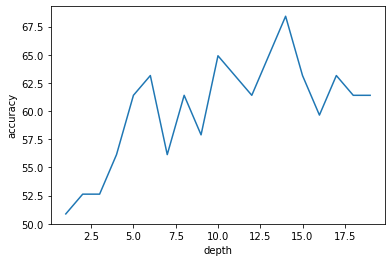

In [19]:
#Random forest
highest_d = 0
highest_acc = 0
accuracy_scores = []
n_list = range(1,20)
for n in n_list:
    RF = RandomForestClassifier(n_estimators=30, max_depth=n, random_state=7)
    RF.fit(X_train, Y_train,sample_weight = SampleWeight)

    accuracy_scores.append(RF.score(X_test, Y_test) * 100)
    
    if RF.score(X_test, Y_test) * 100 > highest_acc:
        highest_acc = RF.score(X_test, Y_test) * 100
        highest_d = n
plt.plot(n_list, accuracy_scores)
plt.xlabel('depth')
plt.ylabel('accuracy')
print("Highest accuracy", highest_acc, " on ", highest_d)

In [20]:
RF = RandomForestClassifier(n_estimators=30, max_depth=14, random_state=7)
RF.fit(X_train, Y_train,sample_weight = SampleWeight)
Trainscore = RF.score(X_train, Y_train)
Testscore = RF.score(X_test, Y_test)
print("Training Accuracy: " + str(Trainscore)) 
print("Test Accuracy: "+ str(Testscore))

Training Accuracy: 0.9688109161793372
Test Accuracy: 0.6842105263157895


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted labels', ylabel='True labels'>

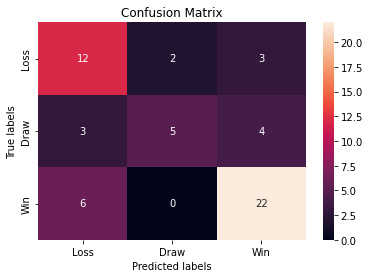

In [21]:
from sklearn.metrics import confusion_matrix 
pred_y = RF.predict(X_test)
cm = confusion_matrix(Y_test, pred_y)
confusion_matrix_plot(cm)

In [22]:
RF = RandomForestClassifier(n_estimators=30, max_depth=14, random_state=7)
RF.fit(X_train, Y_train,sample_weight = SampleWeight)
Trainscore = RF.score(X_train, Y_train)
Testscore = RF.score(X_test, Y_test)
print("Training Accuracy: " + str(Trainscore)) 
print("Test Accuracy: "+ str(Testscore))

Training Accuracy: 0.9688109161793372
Test Accuracy: 0.6842105263157895


In [23]:
y_score = RF.predict_proba(X_test)
Y = label_binarize(Y_test, classes=[-1, 0, 1])
n_classes = Y.shape[1]

In [24]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

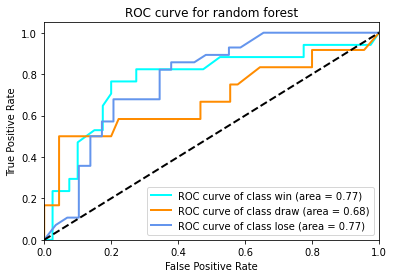

In [25]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
lw = 2

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
class_names = ["win", "draw", "lose"]

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(class_names[i], roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for random forest")
plt.legend(loc="lower right")
plt.show()

## Predict 2022 World Cup Champion

### Input Data Processing

In [26]:
# Predict Word Cup 2022 results
WordCup2022 = pd.read_csv('data/2022WordCup_InputData.csv')
WordCup2022['Rank_Diff'] = WordCup2022['home_fifa_rank'] - WordCup2022['away_fifa_rank']
WordCup2022.head()

,Unnamed: 0,Year,Phase,home_team,home_gdp,home_population,home_oddset,home_fifa_rank,away_team,away_gdp,away_population,away_oddset,away_fifa_rank,result,Rank_Diff
0,0,2022,A,QAT,89969,289,35000,58,ECU,10896,1765,15000,53,0,5
1,1,2022,A,SEN,3503,1675,8000,22,NED,10926,10,200000,16,0,6
2,2,2022,B,ENG,10926,10,200000,4,IRN,13339,8400,50000,31,0,-27
3,3,2022,B,USA,63594,33101,10000,20,UKR,13055,4374,25000,24,0,-4
4,4,2022,D,FRA,46984,6528,550,2,UAE,10926,10,200000,73,0,-71


In [27]:
# Create the new dataframe for Machine Learning input
def create_input(data1,data2):
  Tmp = []
  for index, row in data1.iterrows():
    ProcessedData = {}
    Rate = calculate_rate(data2,row['home_team'],row['away_team'],row['Year'])
    ProcessedData['Year'] = row['Year']
    ProcessedData['Phase'] = row['Phase']
    ProcessedData['home_team'] = row['home_team']
    ProcessedData['away_team'] = row['away_team']
    ProcessedData['result'] = row['result']
    ProcessedData['Rank_Diff'] = row['Rank_Diff']
    ProcessedData['Home_Team_Win_Rate'] = Rate['Home_Team_Win_Rate']
    ProcessedData['Home_Team_Draw_Rate'] = Rate['Home_Team_Draw_Rate']
    ProcessedData['Home_Team_Lose_Rate'] = Rate['Home_Team_Lose_Rate']
    ProcessedData['Away_Team_Win_Rate'] = Rate['Away_Team_Win_Rate']
    ProcessedData['Away_Team_Draw_Rate'] = Rate['Away_Team_Draw_Rate']
    ProcessedData['Away_Team_Lose_Rate'] = Rate['Away_Team_Lose_Rate']
    ProcessedData['Win_Rate_Diff'] = Rate['Win_Rate_Diff']
    ProcessedData['Draw_Rate_Diff'] = Rate['Draw_Rate_Diff']
    ProcessedData['Lose_Rate_Diff'] = Rate['Lose_Rate_Diff']
    ProcessedData['Home_Team_Win_Goals_Avg'] = Rate['Home_Team_Win_Goals_Avg']
    ProcessedData['Home_Team_Lose_Goals_Avg'] = Rate['Home_Team_Lose_Goals_Avg']
    ProcessedData['Away_Team_Win_Goals_Avg'] = Rate['Away_Team_Win_Goals_Avg']
    ProcessedData['Away_Team_Lose_Goals_Avg'] = Rate['Away_Team_Lose_Goals_Avg']
    ProcessedData['Win_Goals_Diff'] = Rate['Win_Goals_Diff']
    ProcessedData['Lose_Goals_Diff'] = Rate['Lose_Goals_Diff']
    ProcessedData['Home_Team_AVG_Goals'] = Rate['Home_Team_AVG_Goals']
    ProcessedData['Away_Team_AVG_Goals'] = Rate['Away_Team_AVG_Goals']
    ProcessedData['AVG_Goals_Diff'] = Rate['AVG_Goals_Diff']
    Tmp.append(ProcessedData)
  Input = pd.DataFrame(Tmp)
  Input = Input.fillna(0)
  return Input

In [28]:
PredInput = create_input(WordCup2022,data_clean)
DropTmp = ['Phase','result','home_team','away_team','Year',
           'Home_Team_Win_Rate', 'Home_Team_Draw_Rate', 'Home_Team_Lose_Rate','Away_Team_Win_Rate', 'Away_Team_Draw_Rate', 'Away_Team_Lose_Rate',
           'Home_Team_Win_Goals_Avg', 'Home_Team_Lose_Goals_Avg','Away_Team_Win_Goals_Avg', 'Away_Team_Lose_Goals_Avg',
           'Home_Team_AVG_Goals', 'Away_Team_AVG_Goals']
PredictX = PredInput.drop(DropTmp, axis=1)
PredictX

,Rank_Diff,Win_Rate_Diff,Draw_Rate_Diff,Lose_Rate_Diff,Win_Goals_Diff,Lose_Goals_Diff,AVG_Goals_Diff
0,5,-0.250000,-0.250000,-0.500000,-0.500000,0.750000,-0.750000
1,6,0.666667,0.000000,0.333333,0.666667,-0.333333,1.000000
2,-27,-0.166667,-0.166667,-0.666667,-0.166667,1.333333,-0.833333
3,-4,-0.142857,0.142857,0.000000,0.000000,1.047619,0.761905
4,-71,0.482759,0.206897,0.310345,0.931034,-0.448276,1.655172
5,-16,-0.111111,-0.222222,-0.666667,-0.222222,1.000000,-0.666667
6,-10,-0.201229,0.018433,0.182796,-0.341014,-0.543779,-0.330261
7,-57,0.627907,0.162791,0.209302,1.186047,-0.232558,1.906977
8,-69,0.379310,0.206897,-0.586207,0.482759,0.741379,1.137931
9,-44,0.407407,0.222222,0.370370,0.814815,-0.592593,1.592593


### Predict Group Results

In [29]:
Pred2022 = RF.predict(PredictX)
print(Pred2022)
PredInput['result'] = Pred2022
PredInput.head()

[ 1  1  1  1  1  1 -1  1  1  1 -1  1  1  1 -1  1  0 -1  1  1  1  1  1  1
 -1  1  1  1 -1  0  0  1 -1 -1  1  1  1 -1 -1 -1  1 -1 -1  1  1 -1  1  1]


,Year,Phase,home_team,away_team,result,Rank_Diff,Home_Team_Win_Rate,Home_Team_Draw_Rate,Home_Team_Lose_Rate,Away_Team_Win_Rate,...,Lose_Rate_Diff,Home_Team_Win_Goals_Avg,Home_Team_Lose_Goals_Avg,Away_Team_Win_Goals_Avg,Away_Team_Lose_Goals_Avg,Win_Goals_Diff,Lose_Goals_Diff,Home_Team_AVG_Goals,Away_Team_AVG_Goals,AVG_Goals_Diff
0,2022,A,QAT,ECU,1,5,0.000000,0.000000,0.000000,0.250000,...,-0.500000,0.000000,0.000000,0.500000,-0.750000,-0.500000,0.750000,0.000000,0.750000,-0.750000
1,2022,A,SEN,NED,1,6,0.666667,0.000000,0.333333,0.000000,...,0.333333,0.666667,-0.333333,0.000000,0.000000,0.666667,-0.333333,1.000000,0.000000,1.000000
2,2022,B,ENG,IRN,1,-27,0.000000,0.000000,0.000000,0.166667,...,-0.666667,0.000000,0.000000,0.166667,-1.333333,-0.166667,1.333333,0.000000,0.833333,-0.833333
3,2022,B,USA,UKR,1,-4,0.190476,0.142857,0.666667,0.333333,...,0.000000,0.333333,-1.285714,0.333333,-2.333333,0.000000,1.047619,1.095238,0.333333,0.761905
4,2022,D,FRA,UAE,1,-71,0.482759,0.206897,0.310345,0.000000,...,0.310345,0.931034,-0.448276,0.000000,0.000000,0.931034,-0.448276,1.655172,0.000000,1.655172


In [30]:
#Let's assign points to each team based on the outcome
PredInput['Home_points'] = PredInput['result'].map({1:3,0:1,-1:0})
PredInput['Away_points'] = PredInput['result'].map({1:0,0:1,-1:3})
# show points for each team after group matches
scores={}
GroupPhase = []
for _, row in PredInput.iterrows():
    if row['home_team'] not in scores:
        scores[row['home_team']]=0
        GroupPhase.append(row['Phase'])
    if row['away_team'] not in scores:
        scores[row['away_team']]=0
        GroupPhase.append(row['Phase'])
    
    if row['result']==1:
        scores[row['home_team']]+=3
    elif row['result']==0:
        scores[row['home_team']]+=1
        scores[row['away_team']]+=1
    else: 
        scores[row['away_team']]+=3

In [31]:
GroupResult = []
for item in scores.items():
    GroupResultTmp = {}
    key = item[0]
    value = item[1]
    GroupResultTmp['Team'] = key
    GroupResultTmp['Points'] = value
    GroupResult.append(GroupResultTmp)
Group = pd.DataFrame(GroupResult)
Group['Phase'] = GroupPhase
GroupNew=Group.sort_values(['Phase', 'Points'], ascending=[True, False]).reset_index(drop=True)
GroupNew

,Team,Points,Phase
0,SEN,6,A
1,NED,6,A
2,QAT,3,A
3,ECU,3,A
4,ENG,6,B
5,USA,6,B
6,UKR,4,B
7,IRN,1,B
8,ARG,9,C
9,POL,6,C


### Predict 8/16 Results

In [32]:
# create new matches using World Cup Rules
# Rule: 'A1-B2','C1-D2','E1-F2','G1-H2','B1-A2','D1-C2','F1-E2','H1-G2'
# get the 16 teams
A1=GroupNew[GroupNew['Phase']=='A']['Team'].iloc[0]
A2=GroupNew[GroupNew['Phase']=='A']['Team'].iloc[1]
B1=GroupNew[GroupNew['Phase']=='B']['Team'].iloc[0]
B2=GroupNew[GroupNew['Phase']=='B']['Team'].iloc[1]
C1=GroupNew[GroupNew['Phase']=='C']['Team'].iloc[0]
C2=GroupNew[GroupNew['Phase']=='C']['Team'].iloc[1]
D1=GroupNew[GroupNew['Phase']=='D']['Team'].iloc[0]
D2=GroupNew[GroupNew['Phase']=='D']['Team'].iloc[1]
E1=GroupNew[GroupNew['Phase']=='E']['Team'].iloc[0]
E2=GroupNew[GroupNew['Phase']=='E']['Team'].iloc[1]
F1=GroupNew[GroupNew['Phase']=='F']['Team'].iloc[0]
F2=GroupNew[GroupNew['Phase']=='F']['Team'].iloc[1]
G1=GroupNew[GroupNew['Phase']=='G']['Team'].iloc[0]
G2=GroupNew[GroupNew['Phase']=='G']['Team'].iloc[1]
H1=GroupNew[GroupNew['Phase']=='H']['Team'].iloc[0]
H2=GroupNew[GroupNew['Phase']=='H']['Team'].iloc[1]

home_team_16=[A1,C1,E1,G1,B1,D1,F1,H1]
away_team_16=[B2,D2,F2,H2,A2,C2,E2,G2]
GameRule=['A1-B2','C1-D2','E1-F2','G1-H2','B1-A2','D1-C2','F1-E2','H1-G2']

Match16 = pd.DataFrame()
Match16['Phase'] = GameRule
Match16['Year'] = 2022
Match16['Home'] = home_team_16
Match16['Away'] = away_team_16

display(Match16)


,Phase,Year,Home,Away
0,A1-B2,2022,SEN,USA
1,C1-D2,2022,ARG,DEN
2,E1-F2,2022,ESP,MAR
3,G1-H2,2022,BRA,POR
4,B1-A2,2022,ENG,NED
5,D1-C2,2022,FRA,POL
6,F1-E2,2022,BEL,CRC
7,H1-G2,2022,GHA,SWE


In [33]:
Attmp = ['Year','Phase','home_team','home_fifa_rank','away_team','away_fifa_rank','result']
PDtmp = pd.DataFrame(columns=Attmp)

In [34]:
# Generate rank for 2022 Teams
def GenerateRank(data1,data2):
  for i in range(len(data1)):
    #year
    data2.loc[i, 'Year'] = data1.loc[i,'Year']
    data2.loc[i, 'Phase'] = data1.loc[i,'Phase']
    #home team
    home = data1.loc[i,'Home']
    data2.loc[i, 'home_team'] = home
    #home fifa rank
    query_home = get_fifa_rank_records(home,2022)
    if(len( query_home['rank'].tolist())>0):
        data2.loc[i, 'home_fifa_rank'] = query_home['rank'].tolist()[0]
    else:
        data2.loc[i, 'home_fifa_rank'] = 211
    # away team
    away = data1.loc[i,'Away']
    data2.loc[i, 'away_team'] = away
    #away fifa rank
    query_away = get_fifa_rank_records(away,2022)
    if(len( query_away['rank'].tolist())>0):
        data2.loc[i, 'away_fifa_rank'] = query_away['rank'].tolist()[0]
    else:
        data2.loc[i, 'away_fifa_rank'] = 211
    data2.loc[i, 'result'] = 0
  return data2

In [35]:
PD16 = GenerateRank(Match16,PDtmp)
PD16['Rank_Diff'] = PD16['home_fifa_rank'] - PD16['away_fifa_rank']
Pred16Input = create_input(PD16,data_clean)
Drop16Tmp = ['Phase','result','home_team','away_team','Year',
           'Home_Team_Win_Rate', 'Home_Team_Draw_Rate', 'Home_Team_Lose_Rate','Away_Team_Win_Rate', 'Away_Team_Draw_Rate', 'Away_Team_Lose_Rate',
           'Home_Team_Win_Goals_Avg', 'Home_Team_Lose_Goals_Avg','Away_Team_Win_Goals_Avg', 'Away_Team_Lose_Goals_Avg',
           'Home_Team_AVG_Goals', 'Away_Team_AVG_Goals']
Predict16X = Pred16Input.drop(Drop16Tmp, axis=1)
Predict16X

/tmp/ipykernel_17592/2771599552.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_records['rank_year'] = country_records['rank_year'].astype(int)
/tmp/ipykernel_17592/2771599552.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_records.sort_values("rank_year",inplace=True, ascending=False)
/tmp/ipykernel_17592/2771599552.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

,Rank_Diff,Win_Rate_Diff,Draw_Rate_Diff,Lose_Rate_Diff,Win_Goals_Diff,Lose_Goals_Diff,AVG_Goals_Diff
0,2,0.476190,-0.142857,-0.333333,0.333333,0.952381,-0.095238
1,-2,0.627907,0.162791,0.209302,1.186047,-0.232558,1.906977
2,-28,0.407407,-0.177778,-0.229630,0.814815,0.807407,1.192593
3,-2,0.706897,0.120690,0.172414,1.689655,-0.258621,2.396552
4,-12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,-19,-0.041051,0.064039,-0.022989,0.073892,0.266010,0.131363
6,-49,0.379310,0.206897,0.413793,0.482759,-0.758621,1.137931
7,31,0.208333,-0.125000,-0.083333,0.166667,0.166667,-0.333333


In [36]:
Pred2022_16 = RF.predict(Predict16X)
print(Pred2022_16)
Pred16Input['result'] = Pred2022_16
Pred16Input.head(10)

[ 1  1  1  1  1  1  1 -1]


,Year,Phase,home_team,away_team,result,Rank_Diff,Home_Team_Win_Rate,Home_Team_Draw_Rate,Home_Team_Lose_Rate,Away_Team_Win_Rate,...,Lose_Rate_Diff,Home_Team_Win_Goals_Avg,Home_Team_Lose_Goals_Avg,Away_Team_Win_Goals_Avg,Away_Team_Lose_Goals_Avg,Win_Goals_Diff,Lose_Goals_Diff,Home_Team_AVG_Goals,Away_Team_AVG_Goals,AVG_Goals_Diff
0,2022,A1-B2,SEN,USA,1,2,0.666667,0.000000,0.333333,0.190476,...,-0.333333,0.666667,-0.333333,0.333333,-1.285714,0.333333,0.952381,1.000000,1.095238,-0.095238
1,2022,C1-D2,ARG,DEN,1,-2,0.627907,0.162791,0.209302,0.000000,...,0.209302,1.186047,-0.232558,0.000000,0.000000,1.186047,-0.232558,1.906977,0.000000,1.906977
2,2022,E1-F2,ESP,MAR,1,-28,0.407407,0.222222,0.370370,0.000000,...,-0.229630,0.814815,-0.592593,0.000000,-1.400000,0.814815,0.807407,1.592593,0.400000,1.192593
3,2022,G1-H2,BRA,POR,1,-2,0.706897,0.120690,0.172414,0.000000,...,0.172414,1.689655,-0.258621,0.000000,0.000000,1.689655,-0.258621,2.396552,0.000000,2.396552
4,2022,B1-A2,ENG,NED,1,-12,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,2022,D1-C2,FRA,POL,1,-19,0.482759,0.206897,0.310345,0.523810,...,-0.022989,0.931034,-0.448276,0.857143,-0.714286,0.073892,0.266010,1.655172,1.523810,0.131363
6,2022,F1-E2,BEL,CRC,1,-49,0.379310,0.206897,0.413793,0.000000,...,0.413793,0.482759,-0.758621,0.000000,0.000000,0.482759,-0.758621,1.137931,0.000000,1.137931
7,2022,H1-G2,GHA,SWE,-1,31,0.500000,0.125000,0.375000,0.291667,...,-0.083333,0.625000,-0.750000,0.458333,-0.916667,0.166667,0.166667,1.125000,1.458333,-0.333333


In [37]:
Match16['Result'] = Pred2022_16
Match16

,Phase,Year,Home,Away,Result
0,A1-B2,2022,SEN,USA,1
1,C1-D2,2022,ARG,DEN,1
2,E1-F2,2022,ESP,MAR,1
3,G1-H2,2022,BRA,POR,1
4,B1-A2,2022,ENG,NED,1
5,D1-C2,2022,FRA,POL,1
6,F1-E2,2022,BEL,CRC,1
7,H1-G2,2022,GHA,SWE,-1


### Predict 4/8 Results

In [38]:
# The winner of A1-B2 will play againts the winner of C1-D2
# The winner of E1-F2 will play againts the winner of G1-H2
# The winner of B1-A2 will play againts the winner of D1-C2
# The winner of F1-E2 will play againts the winner of H1-G2
winners16 = []
for key in Match16['Phase'].unique():
    if Match16[Match16['Phase']==key]['Result'].iloc[0]==1:
        winners16.append(Match16[Match16['Phase']==key]['Home'].iloc[0])
    else:
        winners16.append(Match16[Match16['Phase']==key]['Away'].iloc[0])
home_team_8=[winners16[0], winners16[2],winners16[4],winners16[6]]
away_team_8=[winners16[1], winners16[3],winners16[5],winners16[7]]
GameRule8=['B2-C1','E1-G1','B1-D1','F1-G2']

Match8 = pd.DataFrame()
Match8['Phase'] = GameRule8
Match8['Year'] = 2022
Match8['Home'] = home_team_8
Match8['Away'] = away_team_8

display(Match8)

,Phase,Year,Home,Away
0,B2-C1,2022,SEN,ARG
1,E1-G1,2022,ESP,BRA
2,B1-D1,2022,ENG,FRA
3,F1-G2,2022,BEL,SWE


In [39]:
Attmp = ['Year','Phase','home_team','home_fifa_rank','away_team','away_fifa_rank','result']
PDtmp = pd.DataFrame(columns=Attmp)

In [40]:
PD8 = GenerateRank(Match8,PDtmp)
PD8['Rank_Diff'] = PD8['home_fifa_rank'] - PD8['away_fifa_rank']
Pred8Input = create_input(PD8,data_clean)
Drop8Tmp = ['Phase','result','home_team','away_team','Year',
           'Home_Team_Win_Rate', 'Home_Team_Draw_Rate', 'Home_Team_Lose_Rate','Away_Team_Win_Rate', 'Away_Team_Draw_Rate', 'Away_Team_Lose_Rate',
           'Home_Team_Win_Goals_Avg', 'Home_Team_Lose_Goals_Avg','Away_Team_Win_Goals_Avg', 'Away_Team_Lose_Goals_Avg',
           'Home_Team_AVG_Goals', 'Away_Team_AVG_Goals']
Predict8X = Pred8Input.drop(Drop8Tmp, axis=1)
Predict8X

/tmp/ipykernel_17592/2771599552.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_records['rank_year'] = country_records['rank_year'].astype(int)
/tmp/ipykernel_17592/2771599552.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_records.sort_values("rank_year",inplace=True, ascending=False)
/tmp/ipykernel_17592/2771599552.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

,Rank_Diff,Win_Rate_Diff,Draw_Rate_Diff,Lose_Rate_Diff,Win_Goals_Diff,Lose_Goals_Diff,AVG_Goals_Diff
0,14,0.038760,-0.162791,0.124031,-0.519380,-0.100775,-0.906977
1,3,-0.299489,0.101533,0.197957,-0.874840,-0.333972,-0.803959
2,2,-0.482759,-0.206897,-0.310345,-0.931034,0.448276,-1.655172
3,-17,0.087644,-0.043103,-0.044540,0.024425,0.158046,-0.320402


In [41]:
Pred2022_8 = RF.predict(Predict8X)
print(Pred2022_8)
Pred8Input['result'] = Pred2022_8
Pred8Input.head(10)

[-1 -1 -1 -1]


,Year,Phase,home_team,away_team,result,Rank_Diff,Home_Team_Win_Rate,Home_Team_Draw_Rate,Home_Team_Lose_Rate,Away_Team_Win_Rate,...,Lose_Rate_Diff,Home_Team_Win_Goals_Avg,Home_Team_Lose_Goals_Avg,Away_Team_Win_Goals_Avg,Away_Team_Lose_Goals_Avg,Win_Goals_Diff,Lose_Goals_Diff,Home_Team_AVG_Goals,Away_Team_AVG_Goals,AVG_Goals_Diff
0,2022,B2-C1,SEN,ARG,-1,14,0.666667,0.000000,0.333333,0.627907,...,0.124031,0.666667,-0.333333,1.186047,-0.232558,-0.519380,-0.100775,1.000000,1.906977,-0.906977
1,2022,E1-G1,ESP,BRA,-1,3,0.407407,0.222222,0.370370,0.706897,...,0.197957,0.814815,-0.592593,1.689655,-0.258621,-0.874840,-0.333972,1.592593,2.396552,-0.803959
2,2022,B1-D1,ENG,FRA,-1,2,0.000000,0.000000,0.000000,0.482759,...,-0.310345,0.000000,0.000000,0.931034,-0.448276,-0.931034,0.448276,0.000000,1.655172,-1.655172
3,2022,F1-G2,BEL,SWE,-1,-17,0.379310,0.206897,0.413793,0.291667,...,-0.044540,0.482759,-0.758621,0.458333,-0.916667,0.024425,0.158046,1.137931,1.458333,-0.320402


In [42]:
# Currently unable to deal with the tie issue, choose the higher of the other two as the result
Prob = RF.predict_proba(Predict8X)
Prob

array([[0.575     , 0.29166667, 0.13333333],
       [0.45009121, 0.18888889, 0.3610199 ],
       [0.61666667, 0.01666667, 0.36666667],
       [0.39533443, 0.26461828, 0.34004729]])

In [43]:
Match8['Result'] = Pred2022_8
#Match8.at[3, 'Result'] = 1
Match8

,Phase,Year,Home,Away,Result
0,B2-C1,2022,SEN,ARG,-1
1,E1-G1,2022,ESP,BRA,-1
2,B1-D1,2022,ENG,FRA,-1
3,F1-G2,2022,BEL,SWE,-1


### Predict 2/4 Results

In [44]:
winners8 = []
for key in Match8['Phase'].unique():
    if Match8[Match8['Phase']==key]['Result'].iloc[0]==1:
        winners8.append(Match8[Match8['Phase']==key]['Home'].iloc[0])
    else:
        winners8.append(Match8[Match8['Phase']==key]['Away'].iloc[0])
home_team_4=[winners8[0], winners8[2]]
away_team_4=[winners8[1], winners8[3]]
GameRule4=['S1','S2']

Match4 = pd.DataFrame()
Match4['Phase'] = GameRule4
Match4['Year'] = 2022
Match4['Home'] = home_team_4
Match4['Away'] = away_team_4

display(Match4)

,Phase,Year,Home,Away
0,S1,2022,ARG,BRA
1,S2,2022,FRA,SWE


In [45]:
Attmp = ['Year','Phase','home_team','home_fifa_rank','away_team','away_fifa_rank','result']
PDtmp = pd.DataFrame(columns=Attmp)

In [46]:
PD4 = GenerateRank(Match4,PDtmp)
PD4['Rank_Diff'] = PD4['home_fifa_rank'] - PD4['away_fifa_rank']
Pred4Input = create_input(PD4,data_clean)
Drop4Tmp = ['Phase','result','home_team','away_team','Year',
           'Home_Team_Win_Rate', 'Home_Team_Draw_Rate', 'Home_Team_Lose_Rate','Away_Team_Win_Rate', 'Away_Team_Draw_Rate', 'Away_Team_Lose_Rate',
           'Home_Team_Win_Goals_Avg', 'Home_Team_Lose_Goals_Avg','Away_Team_Win_Goals_Avg', 'Away_Team_Lose_Goals_Avg',
           'Home_Team_AVG_Goals', 'Away_Team_AVG_Goals']
Predict4X = Pred4Input.drop(Drop4Tmp, axis=1)
Predict4X

/tmp/ipykernel_17592/2771599552.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_records['rank_year'] = country_records['rank_year'].astype(int)
/tmp/ipykernel_17592/2771599552.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_records.sort_values("rank_year",inplace=True, ascending=False)
/tmp/ipykernel_17592/2771599552.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

,Rank_Diff,Win_Rate_Diff,Draw_Rate_Diff,Lose_Rate_Diff,Win_Goals_Diff,Lose_Goals_Diff,AVG_Goals_Diff
0,5,-0.078990,0.042101,0.036889,-0.503609,0.026063,-0.489575
1,-16,0.191092,-0.043103,-0.147989,0.472701,0.468391,0.196839


In [47]:
Pred2022_4 = RF.predict(Predict4X)
print(Pred2022_4)
Pred4Input['result'] = Pred2022_4
Pred4Input.head(10)

[-1  1]


,Year,Phase,home_team,away_team,result,Rank_Diff,Home_Team_Win_Rate,Home_Team_Draw_Rate,Home_Team_Lose_Rate,Away_Team_Win_Rate,...,Lose_Rate_Diff,Home_Team_Win_Goals_Avg,Home_Team_Lose_Goals_Avg,Away_Team_Win_Goals_Avg,Away_Team_Lose_Goals_Avg,Win_Goals_Diff,Lose_Goals_Diff,Home_Team_AVG_Goals,Away_Team_AVG_Goals,AVG_Goals_Diff
0,2022,S1,ARG,BRA,-1,5,0.627907,0.162791,0.209302,0.706897,...,0.036889,1.186047,-0.232558,1.689655,-0.258621,-0.503609,0.026063,1.906977,2.396552,-0.489575
1,2022,S2,FRA,SWE,1,-16,0.482759,0.206897,0.310345,0.291667,...,-0.147989,0.931034,-0.448276,0.458333,-0.916667,0.472701,0.468391,1.655172,1.458333,0.196839


In [48]:
Match4['Result'] = Pred2022_4
Match4

,Phase,Year,Home,Away,Result
0,S1,2022,ARG,BRA,-1
1,S2,2022,FRA,SWE,1


### Predict Champion

In [49]:
winners4 = []
for key in Match4['Phase'].unique():
    if Match4[Match4['Phase']==key]['Result'].iloc[0]==1:
        winners4.append(Match4[Match4['Phase']==key]['Home'].iloc[0])
    else:
        winners4.append(Match4[Match4['Phase']==key]['Away'].iloc[0])

home_team_2=[winners4[0]]
away_team_2=[winners4[1]]
GameRule2=['Final']

MatchFianl = pd.DataFrame()
MatchFianl['Phase'] = GameRule2
MatchFianl['Year'] = 2022
MatchFianl['Home'] = home_team_2
MatchFianl['Away'] = away_team_2

display(MatchFianl)

,Phase,Year,Home,Away
0,Final,2022,BRA,FRA


In [50]:
Attmp = ['Year','Phase','home_team','home_fifa_rank','away_team','away_fifa_rank','result']
PDtmp = pd.DataFrame(columns=Attmp)

In [51]:
PDFinal = GenerateRank(MatchFianl,PDtmp)
PDFinal['Rank_Diff'] = PDFinal['home_fifa_rank'] - PDFinal['away_fifa_rank']
PredFinalInput = create_input(PDFinal,data_clean)
DropFinalTmp = ['Phase','result','home_team','away_team','Year',
           'Home_Team_Win_Rate', 'Home_Team_Draw_Rate', 'Home_Team_Lose_Rate','Away_Team_Win_Rate', 'Away_Team_Draw_Rate', 'Away_Team_Lose_Rate',
           'Home_Team_Win_Goals_Avg', 'Home_Team_Lose_Goals_Avg','Away_Team_Win_Goals_Avg', 'Away_Team_Lose_Goals_Avg',
           'Home_Team_AVG_Goals', 'Away_Team_AVG_Goals']
PredictFinalX = PredFinalInput.drop(DropFinalTmp, axis=1)
PredictFinalX

/tmp/ipykernel_17592/2771599552.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_records['rank_year'] = country_records['rank_year'].astype(int)
/tmp/ipykernel_17592/2771599552.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_records.sort_values("rank_year",inplace=True, ascending=False)


,Rank_Diff,Win_Rate_Diff,Draw_Rate_Diff,Lose_Rate_Diff,Win_Goals_Diff,Lose_Goals_Diff,AVG_Goals_Diff
0,1,0.224138,-0.086207,-0.137931,0.758621,0.189655,0.741379


In [52]:
Pred2022Final = RF.predict(PredictFinalX)
print(Pred2022Final)
PredFinalInput['result'] = Pred2022Final
PredFinalInput.head(10)

[-1]


,Year,Phase,home_team,away_team,result,Rank_Diff,Home_Team_Win_Rate,Home_Team_Draw_Rate,Home_Team_Lose_Rate,Away_Team_Win_Rate,...,Lose_Rate_Diff,Home_Team_Win_Goals_Avg,Home_Team_Lose_Goals_Avg,Away_Team_Win_Goals_Avg,Away_Team_Lose_Goals_Avg,Win_Goals_Diff,Lose_Goals_Diff,Home_Team_AVG_Goals,Away_Team_AVG_Goals,AVG_Goals_Diff
0,2022,Final,BRA,FRA,-1,1,0.706897,0.12069,0.172414,0.482759,...,-0.137931,1.689655,-0.258621,0.931034,-0.448276,0.758621,0.189655,2.396552,1.655172,0.741379


In [53]:
MatchFianl['Result'] = Pred2022Final
MatchFianl

,Phase,Year,Home,Away,Result
0,Final,2022,BRA,FRA,-1


In [54]:
#print('The champion is Argentina')

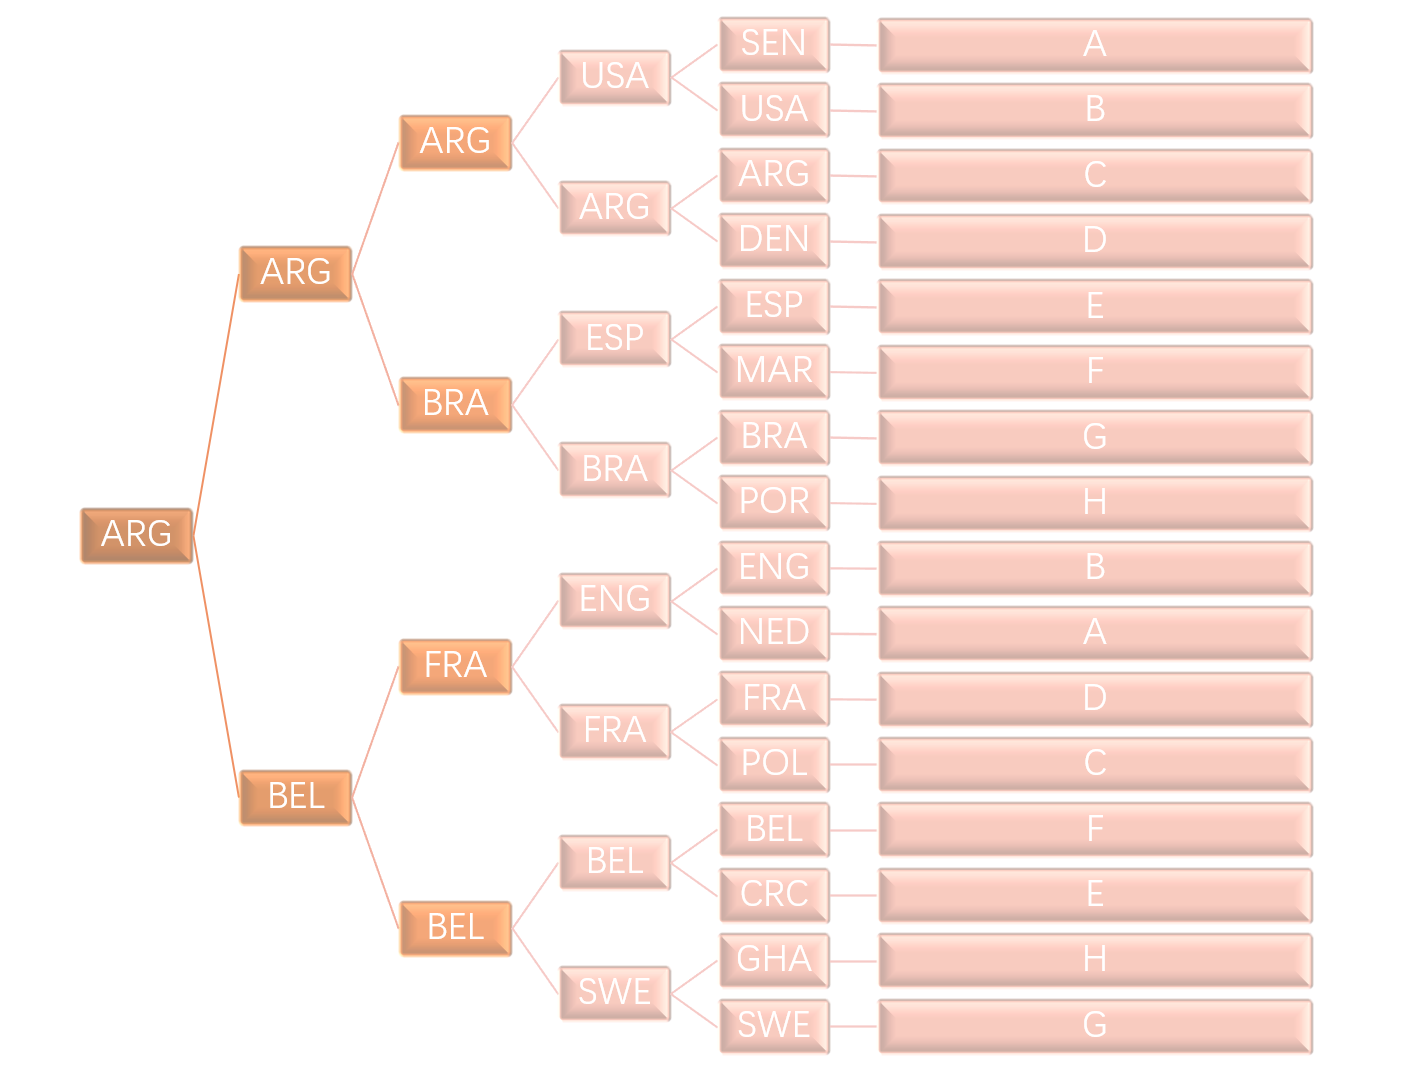